In [1]:
from IPython.display import Image

# MetroMaps

## Report Exercise 3 - Group Coding Topic a1

### Group Members
| Name | Matriculation Number |
|---|---|
| Patric Gruber | 11775839 |
| Christopher Deringer | 01529026 |
| Hannes Marcher | 11776841 |

Github Link: https://github.com/patricgruber/SOMToolbox/ (Branch: `exercise3`)

## 1. Implementation

### a. Requirements
The first decision was the exact requirements we want to implement and we decided on the following:
1. U-Matrix as Background with selectable color mapping
2. User selectable subset of attributes to show
3. Checkboxes for Snapping of the metro lines and labelling
4. Labelling includes the name of the attribute and the high-/low-points
5. Integrated in the already existing framework

An important part to note is that the given framework already contains an implementation of the Metro Map, but it doesn't include labelling and the background is a component plane in case of a single attribute being selected or nothing in case of multiple attributes being selected.

Since this existing code already implemented the computation of the Metro lines in snapped and not snapped form, we decided to reuse this code and create a new visualization with that.

In the code and in the user interface it is called "MetroMap2" to differntiate it with the already existing implementation. It is integrated in the exact same way as the other already given implementations, which means that there is a controller named `MetroMap2Controller` in the `controls/controllers.py` file and a `MetroMap2` class in the `visualizations/metromap2.py` file. Additionally to also show it in the mainview (via `SOMToolbox._mainview` it is also integrated in the `somtoolbox.py` file.

This allows to use the SOMToolbox code as before with a code snipped like:
```py
from somtoolbox import SOMToolbox
from SOMToolBox_Parse import SOMToolBox_Parse

idata = SOMToolBox_Parse("./datasets/10clusters/10clusters.vec").read_weight_file()
attributes = SOMToolBox_Parse("./datasets/10clusters/10clusters.tv").read_tv_file()
weights = SOMToolBox_Parse("./datasets/10clusters/10clusters.wgt").read_weight_file()

sm = SOMToolbox(weights=weights['arr'], m=10, n=10, dimension=10, input_data=idata['arr'], component_names=attributes)
sm._mainview
```
The visualizations dropdown will show the the option `Metro Map 2.0` which is our implemented solution.

### b. Code
As already mentioned the code of the existing MetroMap implementation was copied and modified to fit our needs. These modifications have been made in the visualization class, but also in the controller.

#### I. Visualization
First the background needed to be changed to show the U-Matrix no matter which components are selected. To achieve this, we used the already provided function to compute the U-Matrix and added it to the `visualizations/metromap2.py` file.

The old metro map visualization computed the background like this:
```py
if len(self._controls.components_int) != 1:
    data = hv.Image(self._main._pipe.data).apply.opts(cmap='Blues', color_levels=self._controls.param.water_level, width=self._main._width, height=self._main._height, xlim=self._main._xlim, ylim=self._main._ylim)
else:
    data = hv.Image(self._digitize(self._controls.components_int[0])).apply.opts(cmap='jet', width=self._main._width, height=self._main._height, xlim=self._main._xlim, ylim=self._main._ylim)
```

This code part was replaced by this:
```py
data = hv.Image(UMatrix(self._main._m, self._main._n, self._main._weights, self._main._dim)) \
    .apply \
    .opts(
    cmap=self._main._maincontrol.param.colormap,
    xlim=self._main._xlim,
    ylim=self._main._ylim,
    width=self._main._width,
    height=self._main._height
)
```
The new code uses the UMatrix to compute the data for the `hv.Image` object. For the new image the limitations and dimensions are set as before, but we also include `cmap=self._main._maincontrol.param.colormap` which makes it possible to react to changes of the selected colormap dropdown in the main view.

For the labelling we decided to split it into two parts. First the labelling of the end points which is done in when also drawing the endpoints themselves.

The code to draw the endpoints:
```py
for i, pts in enumerate(lines):
    c = colors.Category20[20][self._controls.components_int[i]]
    overlay.append(hv.Path(np.array(pts)).opts(color=c, line_width=4))
    overlay.append(hv.Points(np.array(pts)).opts(fill_color=c, color='black', size=15))
```

as extended with:
```py
    if self._controls.labelling:
        end, start = pts[0], pts[-1]
        # endpoint labels
        overlay.append(hv.Text(start[0], start[1], "+", 15))
        overlay.append(hv.Text(end[0], end[1], "-", 15))
```
So when drawing the lines themselves and their endpoints we also draw a `+` or `-` on the endpoints if the `self._controls.labelling` parameter is `True`. This is the case when the checkbox has been checked.

The second part is the labelling of the lines themselves with the corresponding attribute name, which was done by the following code:
```py
for i, pts in enumerate(lines):
    c = colors.Category20[20][self._controls.components_int[i]]
    if self._controls.labelling:
        label = self._main._component_names[self._controls.components_int[i]]
        start = pts[-1]

        # attribute label shadow
        overlay.append(hv.Text(start[0] + 0.028, start[1] - 0.003, label, 12, halign='left').opts(color='black'))
        # attribute label
        overlay.append(hv.Text(start[0] + 0.025, start[1], label, 12, halign='left').opts(color=c))
```
As can bee seen here we again iterate over all the lines and drawn the attribute labels seperately. This has the effect that the labels will always be on top of the metro lines and not obstructed by them.

#### II. Controller
The controller manages the controls that are shown, when selecting a visualization. For the controller of the MetroMap2 visualization, we again used the existing `MetroMapController` class, copied it and modified it to our needs.

The first change was to remove the water level controls, as they are not needed for the U-Matrix visualization we chose.
Secondly, we added a checkbox that can be used to show or hide the labels.
This was done by adding the line 
```py
labelling = param.Boolean(False, label='Show labels')
```
Adding only this line will lead to a checkbox being shown, but nothing will change when selecting it, even with the changes in the visualization class. For this to happen we need to react when the checkbox state is changed, by adding the following lines:
```py
@param.depends("labelling", watch=True)
def _change_labels(self, ):
    self._calculate(False)
```
These lines add a watcher to the labelling parameter and if the checkbox is checked or unchecked it will call the `self._calcuate(False)` method, which causes a repaint without recomputation.

To actually use this controller the line:
```py
self._controls = MetroMapController(self._calculate, self._main._dim, self._main._component_names,name='Metro Map visualization')
```
was changed to
```py
self._controls = MetroMap2Controller(self._calculate, self._main._dim, self._main._component_names,name='Metro Map visualization 2.0')
```
in the `MetroMap2` class.

With this change, when our visualization is selected, then there will be a checkbox to (de-)activate the labelling instead of the water levels.

## 2. Tuning, Testing, Comparison
These three parts have their own notbook each, since there is a lot of code and sometimes also a lot of visualizations, so that the main report stays more clean and concise. The following sections include the most important parts of these notebooks and additional explanations.

## 3. Parameter Tuning

The notebook for the whole parameter tuning procedure is `parameter_tuning.ipynb`.
This section summarizes the results.

### 3.1 Parameter Space

To find suitable parameters that perform well on 10clusters and Chainlink, we decided to vary the following SOM parameters:
* sigma
* learning rate
* initialization strategy
* neighborhood function

To train the SOMs we used the library `somoclu` (see https://somoclu.readthedocs.io/en/stable/reference.html for documentation).
The library `somoclu` has no parameter called `sigma` instead it defines two parameters `radius0` and `radiusN` that allow a more fine-grained control of how `sigma` shall behave over time.
Additionally, the parameter `learning rate` is also computed using two parameters `scale0` and `scaleN` that allow to adapt the `learning rate` during the training process.
In essence, we considered the following values as our parameter space:
* (radius0, radiusN): [(min(n_columns, n_rows)/2, 1), (min(n_columns, n_rows)/10, min(n_columns, n_rows)/10), (min(n_columns, n_rows), min(n_columns, n_rows)/2)]
* (scale0, scaleN): [(0.7, 0.7), (0.1, 0.01), (1, 0.01)]
* intialization strategy: [pca, random]
* neighborhood funtion: [bubble, gaussian]

The parameter space covers all the default values of the `somoclu` implementation and, in addition, some extreme parameter configurations such as a learning rate starting at 1 and ending at 0.01.

### 3.2 Experimental Setting

We executed each of the above described parameter settings in conjunction with the default `somoclu` parameters, e.g., when testing for the best (radius0, radiusN) configuration we execturd each value of (radius0, radiusN) one time without changing the other parameter configurations.
Thus, we ended with 10 independent runs for 10clusters and Chainlink, so 20 runs in total (3 times radius + 3 times scale + 2 times initialization + 2 times neighborhood = 10 runs).

To find suitable parameter values we fixed the net size to 20x20 and the epochs to 100 (which is quite a bit since the default epoch number, defined in https://somoclu.readthedocs.io/en/stable/reference.html, is set to 10).
Due to this relatively large epoch number, we expected the SOMs to be accordingly trained and to deliver clear structures. (at least for good parameter configurations)

We found it quite challenging to compare different SOMs soley based on their visualization output,hence to obtain a quantitative measure over the various parameter settings, we used the `mean quantization error` measure.
We figured that low measures of `mean quantization error` represent clear SOM structures quite well.

### 3.3 Results on 10clusters

For some parmeters we obtained quite different results.
For example, when testing for the best setting for (radius0, radiusN), we obtained for (min(n_columns, n_rows)/2, 1) with a `mean quantization error` of 0.34 the follwing SOM (background is a U-Matrix):

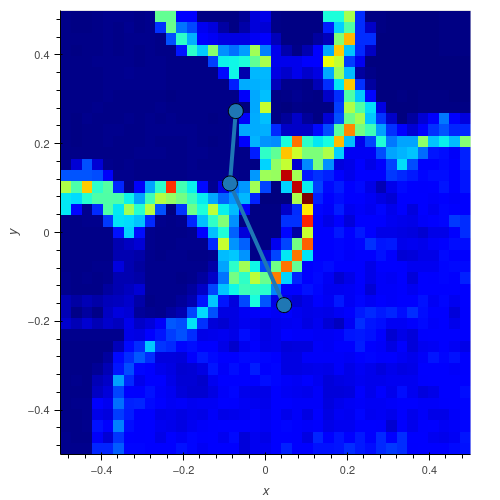

In [2]:
Image(filename = "./images_ex3/paratuning_radius_good.png", width = 500)

However, if we change the same parameter to (min(n_columns, n_rows), min(n_columns, n_rows)/2), we obtain the follwoing SOM with a `mean quantization error` of 1.44:

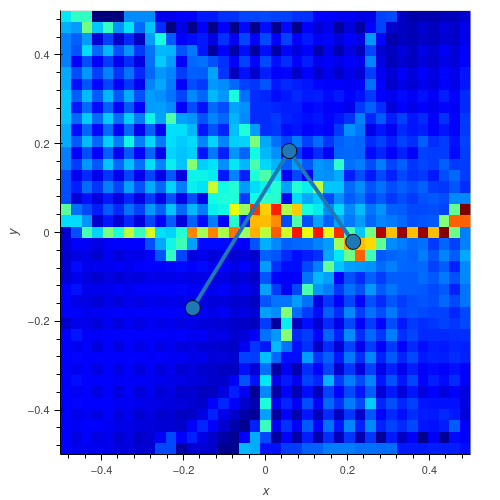

In [3]:
Image(filename = "./images_ex3/paratuning_radius_weak.png", width = 500)

Other parameters seem to be less sensitive.
For instance, if we consider the initialization strategy, then we found nearly no difference between random initialization and pca.
For random initialization we obtained a `mean quantization error` of 0.35 and for pca 0.36, respectively.
The following two plot show the outcome of random initialization:

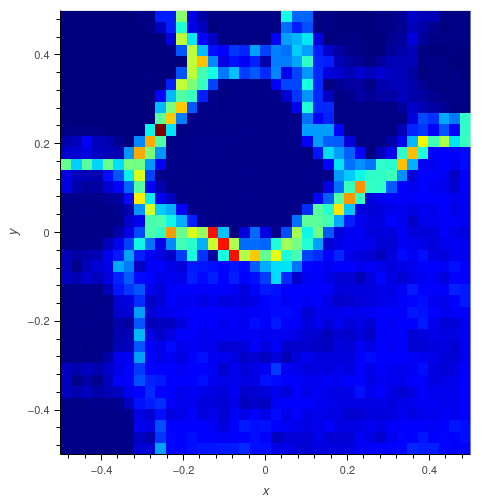

In [4]:
Image(filename = "./images_ex3/paratuning_initialization_random.png", width = 500)

We can see that the 10 clusters are clearly visible.

After comparing the different outcomes, we found the following parameter configuration best performing for 10clusters:
* (radius0, radiusN): (min(n_columns, n_rows)/2, 1)
* (scale0, scaleN): (0.1, 0.01)
* initialization strategy: random
* neighborhood function: gaussian

### 3.4 Results on Chainlink

The results of the individual paramter configurations on Chainlink was quite similar when compared to 10clusters.
We noticed that in general the `mean quanitization error` is much smaller.
The only difference is that we found a different (scale0, scaleN) configuration the best.

The following U-Matrix shows the best performing parameter configuration with a `mean quantization error` of 0.041:

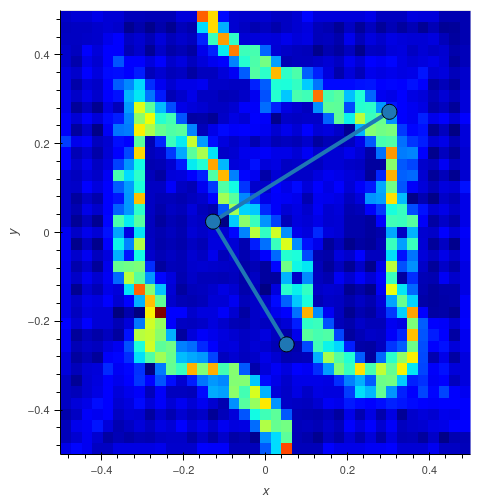

In [5]:
Image(filename = "./images_ex3/paratuning_scale.png", width = 500)

In the end we found the following setting best performing on Chainlink:
* (radius0, radiusN): (min(n_columns, n_rows)/2, 1)
* (scale0, scaleN): (0.7, 0.7)
* initialization strategy: random
* neighborhood function: gaussian

## 4. Testing

## 5. Comparison to the Java SOMToolbox implementation
As dataset we chose use the pretrained Iris dataset that was supplied in the repository. 
We chose the following parameters to compare the two:
1. All attributes are shown
2. Amount of bins is 5
3. Lines are snapped
4. Labels are shown

Our implementation creates the following image:

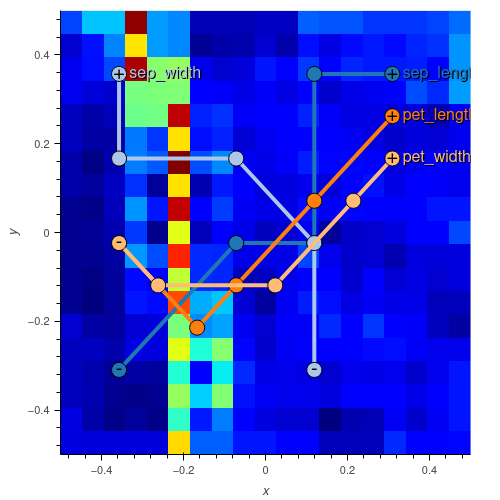

In [6]:
Image(filename = "./images_ex3/iris_metromap_ours.png", width = 500)

The SOMToolbox written in Java produces the following image:

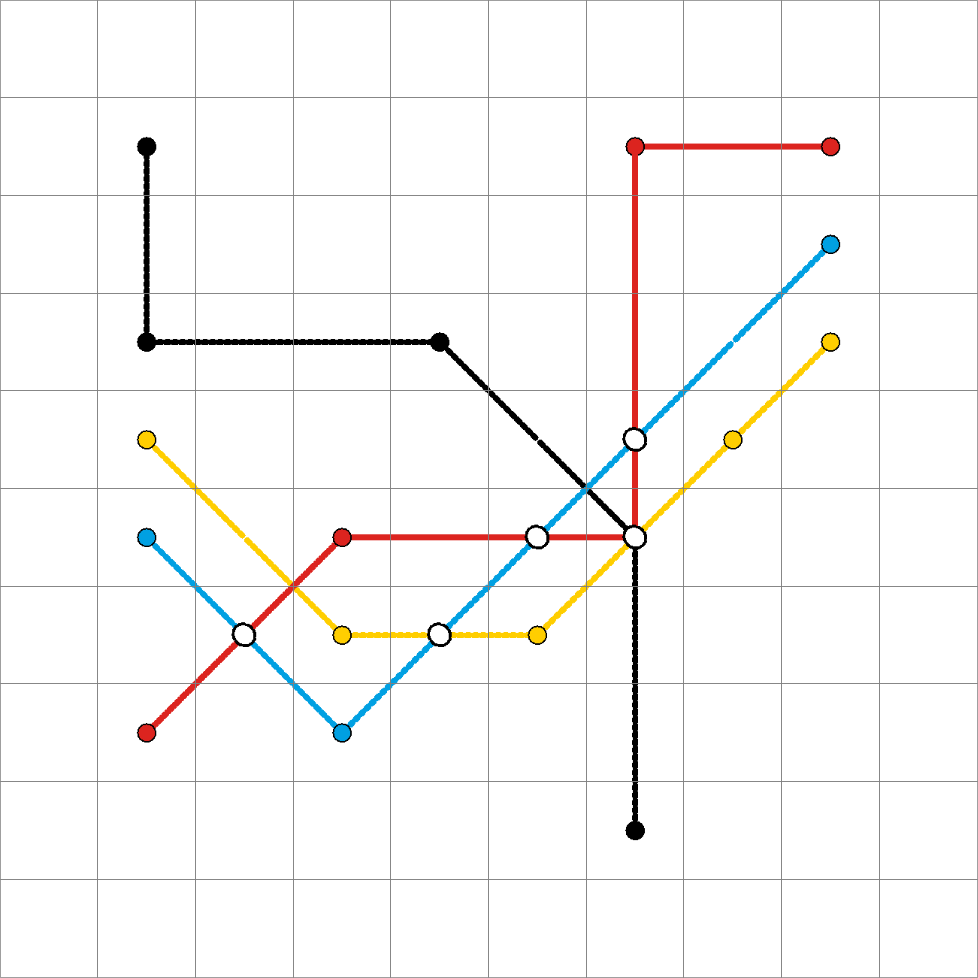

In [7]:
Image(filename = "./images_ex3/iris_metromap_somtoolbox.png", width = 500)

There are several differences between the Java implementation and ours.
1. **Labelling**: The Java implementation doesn't provide any labels. In the application itself we can identify the attributes by checking the corresponding color for each component in the `Metro Map Control` section, but in the exported image there are no labels.
2. **Background**: The Java implementation doesn't have any background visualization. We tried to export the U-Matrix visualization to a PNG, which was then imported as background image in the MetroMap visualization, but nothing was shown. So there is also no U-Matrix visualization as background in the export.
3. **Snapping**: Both implementations offer snapping, but there is a slight difference between the two options. The first one is that stops that are overlapping are shown as white circles with black border in the Java implementation, but there is no special handling for those overlapping stops in our implementation. Additionally, the Java implementation handles overlapping line segments, by showing both, but with a small margin between them, which allows to always see the lines. In our implementation the lines just overlap and there is not handling of this case.